In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import defmod.multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.model_graddesc as model
import scipy.optimize


torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
nb_pts1 = 7
nb_pts2 = 7
dim = 2

o1 = torch.tensor([0.,-1.])
o2 = torch.tensor([6.,3.])
origin = [o1,o2]
r1 = 2
r2 = 1
radius = [r1, r2]
nb_pts = [nb_pts1, nb_pts2]
source = mm.multipleCircles(origin, radius, nb_pts)

origin_target = [[0.,2.], [6.,1.]]

target = mm.multipleCircles(origin_target, radius, nb_pts)

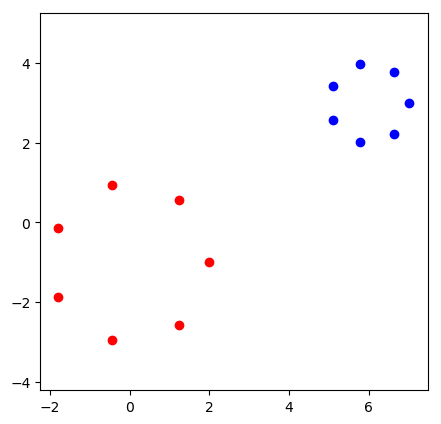

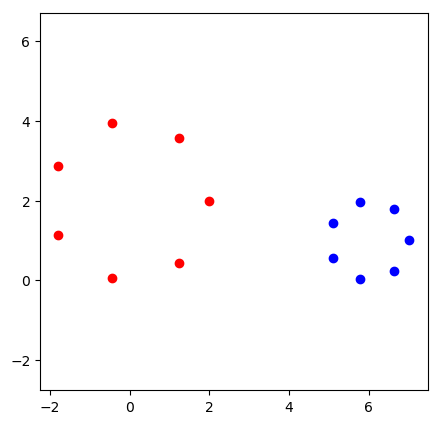

In [3]:
figsize = (5,5)
dpi = 100

fig_source = plt.figure(figsize=figsize, dpi=100)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize=figsize, dpi=100)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [6]:
# Defining the deformation modules
sigma1 = 5.
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
#trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
#trans1 = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1, gd=torch.mean(source[0],0)), sigma=1.)
#trans1 = dm.deformationmodules.Translations(dm.manifold.Landmarks(2, 2, gd=torch.tensor([[0.,0.],[1.,1.]], requires_grad=True).view(-1)), sigma=1.)
trans1 = dm.deformationmodules.Translations(manifold1, 1.5)
trans1.fill_controls_zero()
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy(retain_grad=False))

mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma2 = 5
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
#trans2 = dm.deformationmodules.Translations(manifold2, 0.5)
trans2.fill_controls_zero()
silent2 = silent1 = dm.deformationmodules.SilentPoints(manifold2.copy(retain_grad=False))


mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.5
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [11]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [12]:
# set parameters
reg_param = 10**-3

gd0_tensor = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom0_tensor = torch.zeros(gd0_tensor.shape).requires_grad_().view(-1)
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
E = model.EnergyFunctional(modules, H, constr_Id, source, target, dim, reg_param)
#E = model.EnergyFunctional(modules, H, constr_Id, [source[1]], [target[1]], dim, reg_param)

X = [gd0_tensor, mom0_tensor]

In [16]:
from defmod import optimize
X[1] = optimize.BFGS(E, X, disp=True)(maxiter=50)

cost: 0.00983730594537 attach: 2.243040965943898e-05
cost: 0.00983730594537 attach: 2.243040965943898e-05
cost: 0.00909486183371 attach: 8.212563185853103
cost: 0.00909486183371 attach: 8.212563185853103
cost: 0.00963344963164 attach: 0.8979864787002398
cost: 0.00963344963164 attach: 0.8979864787002398
cost: 0.00981498855613 attach: 0.09199345018235118
cost: 0.00981498855613 attach: 0.09199345018235118
cost: 0.0098350135987 attach: 0.009378422597147218
cost: 0.0098350135987 attach: 0.009378422597147218
cost: 0.00983707126789 attach: 0.0009512708434305233
cost: 0.00983707126789 attach: 0.0009512708434305233
cost: 0.00983728121342 attach: 9.516309732832835e-05
cost: 0.00983728121342 attach: 9.516309732832835e-05
cost: 0.00983730251281 attach: 2.4354033634120897e-05
cost: 0.00983730251281 attach: 2.4354033634120897e-05
cost: 0.00983730493695 attach: 2.174426118587373e-05
cost: 0.00983730493695 attach: 2.174426118587373e-05
cost: 0.00983730947979 attach: 2.137877060115608e-05
cost: 0.00983

In [17]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

H.geodesic_controls()
constr_Id(H.module)


tensor([[ 1.6653e-16,  9.4716e-16],
        [ 1.6653e-16,  3.8858e-16],
        [ 7.6328e-17,  2.7756e-17],
        [-2.2204e-16,  9.7145e-16],
        [-1.6653e-16,  1.7764e-15],
        [-1.1102e-16, -7.7716e-16],
        [ 1.1102e-16, -3.3307e-16],
        [ 3.9829e-01, -2.5599e+00],
        [ 1.8413e-01, -2.2834e+00],
        [-7.4114e-02, -2.2532e+00],
        [-3.4860e-01, -2.4026e+00],
        [-4.6492e-01, -2.8227e+00],
        [-1.4594e-01, -3.1984e+00],
        [ 3.0958e-01, -3.0436e+00]], grad_fn=<CatBackward>)

In [ ]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [ ]:
# Visualization of grid deformation for each submodule
xmin = -5
xmax = 10
ymin = -5
ymax = 5
dx = 0.2
dy = 0.2
nx = int((xmax-xmin)/dx)
ny = int((ymax-ymin)/dy)
x,y,gridpoints = mm.gridpoints(xmin, xmax, ymin, ymax, dx, dy)

In [ ]:
# TO DO: Find Bug in largeDeformation function
#phi = mm.largeDeformation(modules, states, controls, gridpoints)
#x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
#x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
#x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)

#fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
#fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
#fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
#plt.show()

#phi_grid = []
#for a in range(len(phi)):
#    phi_grid.append(dm.usefulfunctions.vec2grid(phi[a], nx, ny))
#plt.figure()
#_,_ = mm.plot_MultiGrid(phi_grid, [x, y], label)
#plt.show()

In [ ]:
label = mm.point_labels(source, gridpoints).view(nx, ny)


In [ ]:
H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
grid_states, grid_controls, grid_intermediate = dm.shooting.shoot_euler_silent(H, gridpoints, it=10)

grid_final = grid_intermediate[-1]

In [ ]:
x1, y1 = dm.usefulfunctions.vec2grid(grid_final[0], nx,ny)
x2, y2 = dm.usefulfunctions.vec2grid(grid_final[1], nx,ny)
x3, y3 = dm.usefulfunctions.vec2grid(grid_final[2], nx,ny)


fig_grid1 = mm.plot_grid(x1.detach().numpy(), y1.detach().numpy(), color = 'blue', xlim=[-5,xmax], ylim=[-5,5], figsize=figsize, dpi=dpi)
fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue', xlim=[-5,xmax], ylim=[-5,5], figsize=figsize, dpi=dpi)
fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue', xlim=[-5,xmax], ylim=[-5,5], figsize=figsize, dpi=dpi)
plt.show()

In [ ]:
label = mm.point_labels(source, gridpoints).view(nx, ny)
phi_grid = []

plt.figure()
mm.plot_MultiGrid([[x1,y1], [x2,y2], [x3,y3]], [x, y], xlim=[xmin,xmax], ylim=[-5,5],label=label)
plt.show()

In [ ]:
sigma_bg

In [ ]:
## LDDMM Module

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
module_LDDMM = dm.deformationmodules.CompoundModule([dm.deformationmodules.Translations(man_compound, sigma=0.5)])
H_LDDMM = dm.hamiltonian.Hamiltonian([module_LDDMM])

attach = dm.attachement.L2NormAttachement()
Energy_LDDMM = model.EnergyFunctional_unconstrained(module_LDDMM, H_LDDMM, [torch.cat(source)], [torch.cat(target)], dim=2, gamma=reg_param, attach=attach)
gd0 = torch.cat(module_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(module_LDDMM.manifold.unroll_cotan())
X_LDDMM = [gd0, mom0]

X_LDDMM[1] = optimize.BFGS(Energy_LDDMM, X_LDDMM, disp=True)(maxiter=250)

In [ ]:
H_LDDMM.module.manifold.fill_gd(X_LDDMM[0])
H_LDDMM.module.manifold.fill_cotan(X_LDDMM[1])

states, controls = dm.shooting.shoot_euler(H_LDDMM, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0].gd.view(-1,2)[:, 0].detach().numpy(), s[0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [ ]:
# Visualization of grid deformation for LDDMM
xmin = -5
xmax = 5
ymin = -5
ymax = 5
dx = 0.05
dy = 0.05
nx = int((xmax-xmin)/dx)
ny = int((ymax-ymin)/dy)
x,y,gridpoints = mm.gridpoints(xmin, xmax, ymin, ymax, dx, dy)

H.module.manifold.fill_gd(X[0])
H.module.manifold.fill_cotan(X[1])
grid_states, grid_controls, grid_intermediate = dm.shooting.shoot_euler_silent(H, gridpoints, it=10)

x1, y1 = dm.usefulfunctions.vec2grid(grid_final[0], nx,ny)
x2, y2 = dm.usefulfunctions.vec2grid(grid_final[1], nx,ny)
x3, y3 = dm.usefulfunctions.vec2grid(grid_final[2], nx,ny)


fig_grid1 = mm.plot_grid(x1.detach().numpy(), y1.detach().numpy(), color = 'blue', xlim=[-5,5], ylim=[-5,5], figsize=figsize, dpi=dpi)
fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue', xlim=[-5,5], ylim=[-5,5], figsize=figsize, dpi=dpi)
fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue', xlim=[-5,5], ylim=[-5,5], figsize=figsize, dpi=dpi)
plt.show()



In [ ]:
## LDDMM Multishape Module
man_list = [dm.manifold.Landmarks(2, len(source[i]), gd = source[i].view(-1).clone()) for i in range(len(source))]
multi_LDDMM = dm.multishape.MultiShapeLDDMM(man_list, [10., 10., sigma_bg])
constr = dm.constraints.Identity()
H_multi_LDDMM = dm.hamiltonian_multishape.Hamiltonian_multi(multi_LDDMM, constr)

#attach = dm.attachement.L2NormAttachement()
Energy_multi_LDDMM = model.EnergyFunctional(multi_LDDMM, H_multi_LDDMM, constr, source, target, dim=2, gamma=reg_param)
gd0 = torch.cat(multi_LDDMM.manifold.unroll_gd())
mom0 = torch.cat(multi_LDDMM.manifold.unroll_cotan())
X_multi_LDDMM = [gd0, mom0]


X_multi_LDDMM[1] = optimize.BFGS(Energy_multi_LDDMM, X_multi_LDDMM, disp=True)(maxiter=5)

In [ ]:
H_multi_LDDMM.geodesic_controls()
constr(H_multi_LDDMM.module)

In [ ]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])

In [ ]:
H_multi_LDDMM.module.manifold.fill_gd(X_multi_LDDMM[0])
H_multi_LDDMM.module.manifold.fill_cotan(X_multi_LDDMM[1])

states, controls = dm.shooting.shoot_euler(H_multi_LDDMM, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [ ]:
## Unconstrained Compound Module

man_compound = dm.manifold.Landmarks(2, manifold1.nb_pts + manifold2.nb_pts, gd = torch.cat(source).view(-1))
trans1_comp = dm.deformationmodules.GlobalTranslation(manifold1, sigma = 10.)
trans1_comp.fill_controls_zero()
trans2_comp = dm.deformationmodules.GlobalTranslation(manifold2, sigma = 10.)
trans2_comp.fill_controls_zero()

module_compound = dm.deformationmodules.CompoundModule([trans1_comp, trans2_comp])
H_compound = dm.hamiltonian.Hamiltonian(module_compound)

attach = dm.attachement.L2NormAttachement()
Energy_compound = model.EnergyFunctional_unconstrained(module_compound, H_compound, source, target, dim=2, gamma=reg_param, attach=attach)
gd0_c = torch.cat(module_compound.manifold.unroll_gd())
mom0_c = torch.cat(module_compound.manifold.unroll_cotan())
X_compound = [gd0_c, mom0_c]

def fun_compound(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return Energy_compound.energy_tensor(gd0_c, Y).detach().numpy()

def jac_compound(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return Energy_compound.gradE_autograd(gd0_c, Y).detach().numpy()


#args = [EnergyFunctional]

In [ ]:
## Optimisation for unconstrained compound
res_compound = scipy.optimize.minimize(fun_compound, mom0_c.detach().numpy(),
                              method='BFGS',
                              jac=jac_compound,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  #'maxcor': 10,
                                  #'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  #'maxfun': 500,
                                  'maxiter': 500,
                                  #'iprint': 1,
                                  #'maxls': 25
                                  'disp' : True
                              })

In [ ]:
X_compound[1] = torch.tensor(res_compound.x)

H_compound.module.manifold.fill_gd(X_compound[0])
H_compound.module.manifold.fill_cotan(X_compound[1])

states, controls = dm.shooting.shoot_euler(H_compound, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = figsize, dpi=100)
for s,c in zip(states, colors):
    plt.scatter(s[0].gd.view(-1,2)[:, 0].detach().numpy(), s[0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.scatter(s[1].gd.view(-1,2)[:, 0].detach().numpy(), s[1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)

    plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
plt.axis('equal')
plt.show()

In [ ]:
# Visualization of grid deformation for single shape Deformation Modules
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation_unconstrained(module_compound, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi, nx, ny)

fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue', figsize=figsize, dpi=dpi)
plt.show()


In [ ]:
def compute_deformation_grid(grid_origin, grid_size, grid_resolution, it=2, intermediate=False):
    x, y = torch.meshgrid([
        torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
        torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

    gridpos = dm.usefulfunctions.grid2vec(x, y)

    grid_landmarks = dm.manifold.Landmarks(2, gridpos.shape[0], gd=gridpos.view(-1))
    grid_silent = dm.deformationmodules.SilentPoints(grid_landmarks)

    intermediate = dm.shooting.shoot_euler(dm.hamiltonian_multishape.Hamiltonian_multi(dm.multishape.MultiShapeModule([grid_silent, *modules.module_list]), constr_Id), it=10)

    return dm.usefulfunctions.vec2grid(grid_landmarks.gd.view(-1, 2).detach(), grid_resolution[0], grid_resolution[1])

compute_deformation_grid(torch.tensor([-3.,-3.]), torch.tensor([15.,10.]), torch.Size([16,16]))

In [ ]:
fig_shooting.savefig('results/circles_translation/shooting.png')
fig_source.savefig('results/circles_translation/source.png')
fig_target.savefig('results/circles_translation/target.png')

fig_grid1.savefig('results/circles_translation/grid1.png')
fig_grid2.savefig('results/circles_translation/grid2.png')
fig_grid_bg.savefig('results/circles_translation/grid_bg.png')

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
gd = gd0_tensor
mom = 1000*torch.rand(gd.shape)


test_gradcheck_Hamiltonian()

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        #H.geodesic_controls()
        #return H()
        mod.compute_geodesic_control_from_self(mod.manifold)
        return mod.controls
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

mod = H.module.module_list[0].copy()

#gd0_tensor = torch.cat(mod.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
#gd = gd0_tensor
#mom = 1000*torch.rand(gd.shape)

gd = torch.cat(mod.manifold.gd).clone().requires_grad_()
mom = torch.cat(mod.manifold.cotan).clone().requires_grad_()


test_gradcheck_Hamiltonian()

In [ ]:
# Defining the deformation modules
sigma1 = 20
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=source[0].view(-1))
trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
trans1.fill_controls_zero()
#trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1.copy())
mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])

sigma_scaling = 1.
a = torch.sqrt(torch.tensor(3.))
direc_scaling_pts = torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
direc_scaling_vec =  torch.tensor([[1., 0.], [-0.5 , 0.5* a],  [-0.5, -0.5* a]], requires_grad=True, dtype=torch.float64)
def f(x):
    centre = x.view(1,2).repeat(3,1)
    return centre + 0.3 * sigma_scaling * direc_scaling_pts

def g(x):
    return direc_scaling_vec
scaling0 = dm.deformationmodules.ConstrainedTranslations(dm.manifold.Landmarks(2, 1, gd = torch.tensor([0.,0.]).view(-1).requires_grad_()), f, g, sigma_scaling)

man_scal = dm.manifold.Landmarks(2,1, gd=torch.tensor([0.,0.]).view(-1).requires_grad_())
scal = dm.deformationmodules.LocalScaling(man_scal, sigma=5.)
sigma2 = 20
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=source[1].view(-1))
trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)
trans2.fill_controls_zero()
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2.copy())
mod2 = dm.deformationmodules.CompoundModule([silent2, trans2, scal])


module_list = [mod1, mod2]
sigma_bg = 5.
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [ ]:
dty = torch.float64
gd0 = torch.tensor([-1., 0.], requires_grad=True, dtype=dty)
gd1 = torch.tensor([1., 0.], requires_grad=True, dtype=dty)

nb_pts = source[0].shape[0]
man_silent = dm.manifold.Landmarks(2, nb_pts, gd=source[0].view(-1).requires_grad_())
man_scal1 = dm.manifold.Landmarks(2,1,gd=gd0)
man_scal2 = dm.manifold.Landmarks(2,1,gd=gd1)

sigma_scaling = 1.
silent = dm.deformationmodules.SilentPoints(man_silent)
scal1 = dm.deformationmodules.LocalScaling(man_scal1, sigma = sigma_scaling)
scal2 = dm.deformationmodules.LocalScaling(man_scal2, sigma = sigma_scaling)
trans = dm.deformationmodules.Translations(dm.manifold.Landmarks(2,1,gd = torch.tensor([0.,0.]).view(-1).requires_grad_()), sigma=400, coeff=5.)

comp1 = dm.deformationmodules.CompoundModule([silent, scal1, scal2, trans])

modules = dm.multishape.MultiShapeModule([comp1], sigma_bg)
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [ ]:
def test_gradcheck():
    def fun(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        mod.compute_geodesic_control_from_self(mod.manifold.copy(retain_grad=True))
        return mod.controls
    return torch.autograd.gradcheck(fun, (gd, mom), raise_exception=True)

mod = dm.deformationmodules.CompoundModule([silent1, trans1])
#h = hamiltonian.Hamiltonian_multi(dm.multishape.MultiShapeModule(modlist, sigma_bg), constr_Id)

gd = torch.cat(mod.manifold.gd.copy()).detach().requires_grad_()
mom = torch.cat(mod.manifold.cotan.copy()).detach().requires_grad_()

test_gradcheck()

In [ ]:
H.module.module_list[0].module_list

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
        return H()
    
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy()).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy()).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()